# 모듈 임포트 및 데이터 로드

In [1]:
#!pip install prophet

In [2]:
#!pip install pystan

In [3]:
from tqdm.auto import tqdm
import random
import os

import torch

import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
import numpy as np
import pandas as pd

In [4]:
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

reset_seeds()

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
!pip install -U finance-datareader

In [7]:
import FinanceDataReader as fdr

In [8]:
df_krx = fdr.StockListing('KRX')
df_krx.head()

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,72900,2,-400,-0.55,73300,73400,72800,9690551,708307183627,435197147895000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,140000,3,0,0.00,139000,140800,138900,2540812,355274996550,101920331100000,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,422000,3,0,0.00,429500,430000,422000,207795,88163935000,98748000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,701000,2,-2000,-0.28,705000,706000,700000,52926,37167153000,49892974000000,71174000,STK
4,005935,KR7005931001,삼성전자우,KOSPI,,59000,2,-300,-0.51,59300,59300,58700,857002,50493422200,48550315300000,822886700,STK


In [9]:
df_kospi = df_krx[df_krx['Market'] == 'KOSPI']
df_kospi

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,72900,2,-400,-0.55,73300,73400,72800,9690551,708307183627,435197147895000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,140000,3,0,0.00,139000,140800,138900,2540812,355274996550,101920331100000,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,422000,3,0,0.00,429500,430000,422000,207795,88163935000,98748000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,701000,2,-2000,-0.28,705000,706000,700000,52926,37167153000,49892974000000,71174000,STK
4,005935,KR7005931001,삼성전자우,KOSPI,,59000,2,-300,-0.51,59300,59300,58700,857002,50493422200,48550315300000,822886700,STK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2770,014915,KR7014911002,성문전자우,KOSPI,,7300,1,570,8.47,6760,7300,6760,3118,22056300,4380000000,600000,STK
2772,002785,KR7002781003,진흥기업우B,KOSPI,,4860,2,-160,-3.19,4850,5000,4850,1089,5467180,4166079480,857218,STK
2774,001525,KR7001521004,동양우,KOSPI,,6240,1,90,1.46,6470,6470,6190,1045,6641380,3854641440,617731,STK
2776,002787,KR7002782001,진흥기업2우B,KOSPI,,12600,2,-150,-1.18,12600,12620,12500,161,2092660,3714580800,294808,STK


In [10]:
def get_stock_data(item_name, year=2020):
    df_krx = fdr.StockListing('KRX')
    df_kospi = df_krx[df_krx['Market'] == 'KOSPI']

    def item_code_by_item_name(item_name):
        item_code_list = df_kospi.loc[df_kospi["Name"] == item_name, "Code"].tolist()
        if len(item_code_list) > 0:
            item_code = item_code_list[0]
            return item_code
        else:
            return None

    def find_item_list(item_name, year=2020):
        item_code = item_code_by_item_name(item_name)
        if item_code:
            df_day = fdr.DataReader(item_code, str(year))
            return df_day
        else:
            return None

    df = find_item_list(item_name, year)
    return df

# 모델 세팅 및 학습, 예측

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
def preprocess_data(df):
    data = df['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    return scaled

def train_prophet_model(df, days_to_predict):
    df['ds'] = pd.to_datetime(df.index)
    df['y'] = df['Close']

    # 주말을 제외한 사용자 정의 휴일 데이터프레임 생성
    holidays = pd.DataFrame({
        'holiday': 'weekday',
        'ds': pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='B')
    })

    model = Prophet(daily_seasonality=True, holidays=holidays)
    model.fit(df[['ds', 'y']])

    # 'B' 주기를 사용하여 평일만 예측하도록 future 데이터프레임 생성
    future = model.make_future_dataframe(periods=days_to_predict, freq='B')
    forecast = model.predict(future)

    # 실제값과 예측값 추출
    y_true = df['y']
    y_pred = forecast['yhat'][:-days_to_predict]  # 예측값 중에서 실제값과 대응되는 부분만 선택

    # MAE와 MSE 계산
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')

    return model, forecast

def plot_prophet_forecast(model, forecast):
    model.plot(forecast)
    plt.show()

def save_forecast_to_dataframe(df, forecast, stock_name):
    forecast_df = forecast[['ds', 'yhat']].tail(14).rename(columns={'ds': 'Date', 'yhat': 'Predicted_Close'})
    forecast_df['Stock'] = stock_name
    return forecast_df

20:37:27 - cmdstanpy - INFO - Chain [1] start processing
20:37:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 1728.3873507283686
Mean Squared Error (MSE): 5019179.622603157


c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


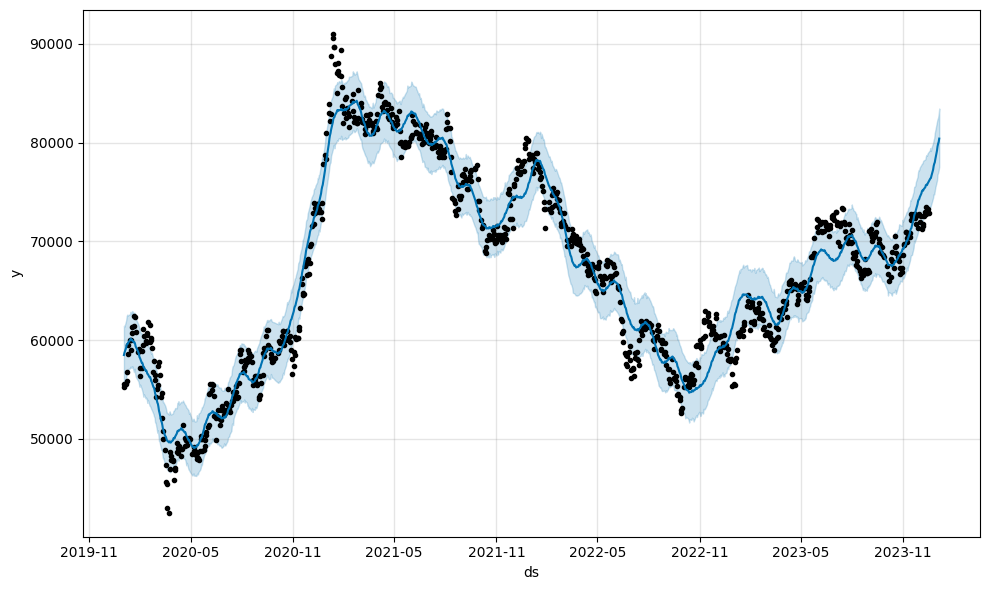

20:37:31 - cmdstanpy - INFO - Chain [1] start processing
20:37:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 8618.420522207573
Mean Squared Error (MSE): 108614841.24746883


c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


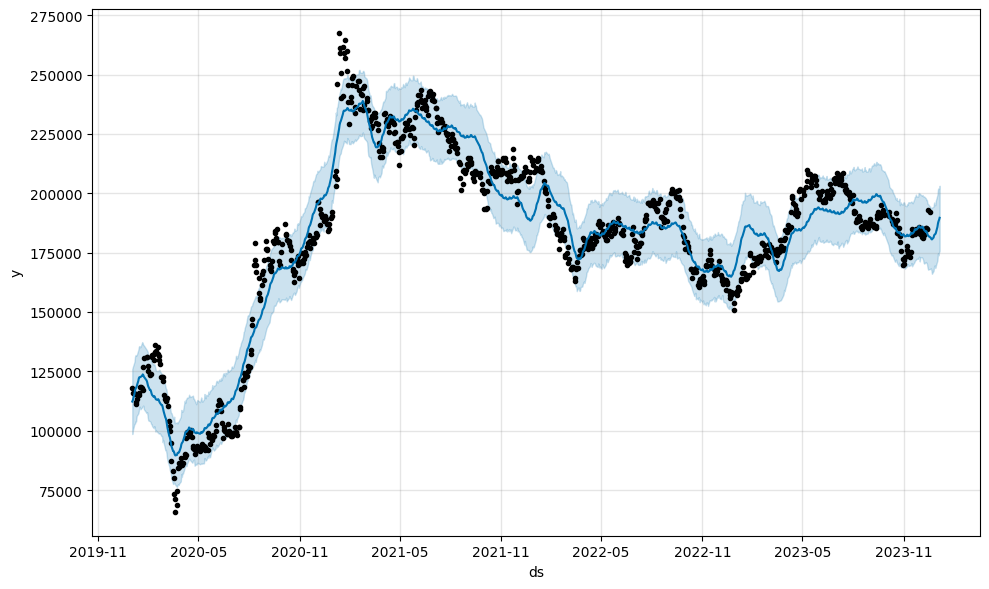

20:37:35 - cmdstanpy - INFO - Chain [1] start processing
20:37:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 37048.925456267876
Mean Squared Error (MSE): 2101623422.2483697


c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


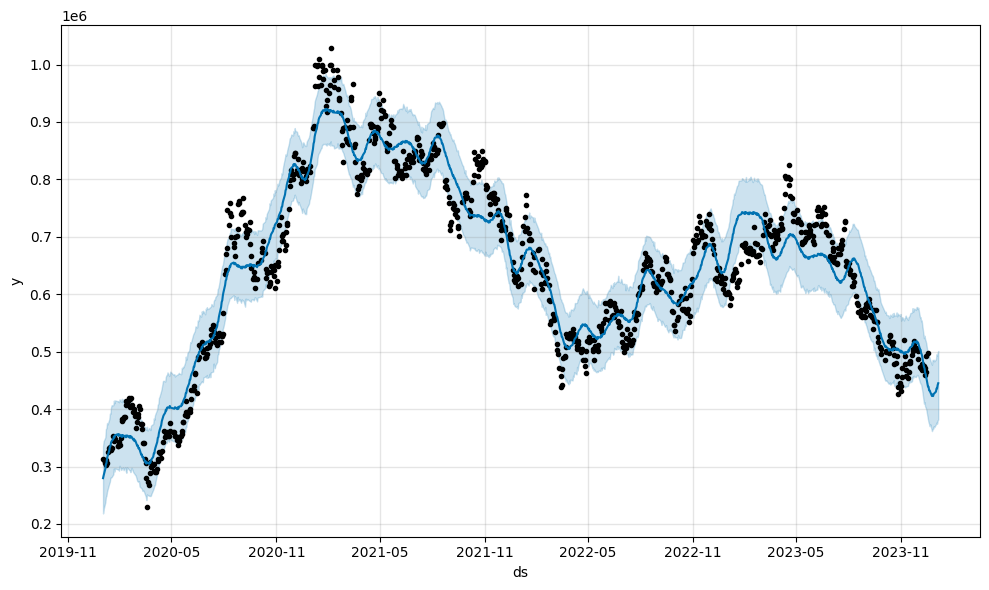

20:37:41 - cmdstanpy - INFO - Chain [1] start processing
20:37:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 25207.30445770371
Mean Squared Error (MSE): 1079680674.4150317


c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


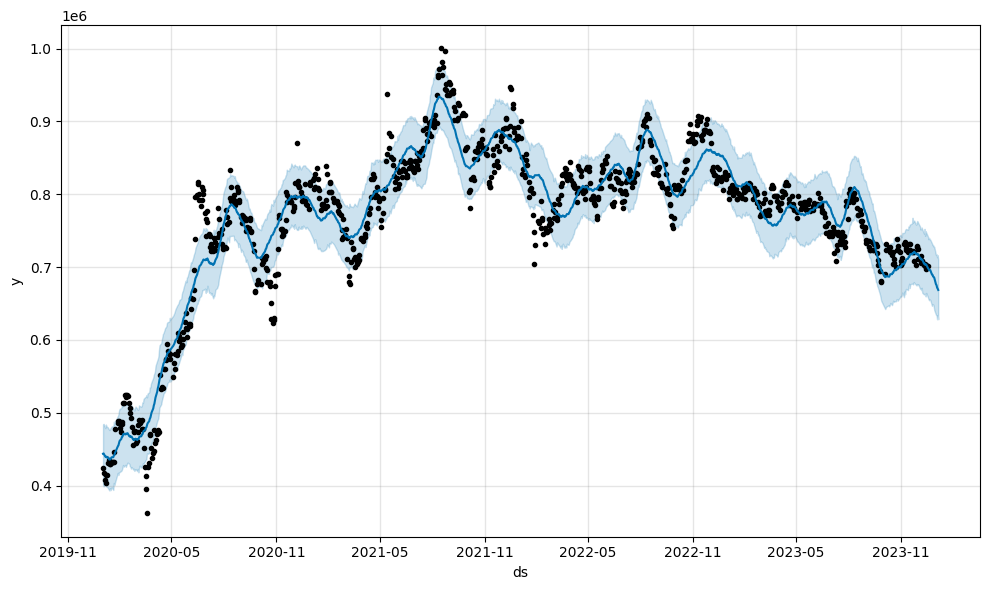

In [13]:
# 예측을 위한 주식 종목 리스트
stock_list = ["삼성전자", "현대차", "LG화학", "POSCO", "삼성바이오로직스"]

forecast_list = []

# 모든 주식 종목에 대한 예측 수행
for stock in stock_list:
    df_stock = get_stock_data(stock, year=2020)
    if df_stock is not None:
        scaled_data = preprocess_data(df_stock)

        # Train Prophet model
        model, forecast = train_prophet_model(df_stock, days_to_predict=14)

        # Plot forecast
        plot_prophet_forecast(model, forecast)

        # Save forecast to dataframe
        forecast_df = save_forecast_to_dataframe(df_stock, forecast, stock)
        forecast_list.append(forecast_df)

In [14]:
forecast_list[0]

,Date,Predicted_Close,Stock
980,2023-12-19,76242.272698,삼성전자
981,2023-12-20,76359.275233,삼성전자
982,2023-12-21,76397.467669,삼성전자
983,2023-12-22,76629.096033,삼성전자
984,2023-12-25,77249.723491,삼성전자
985,2023-12-26,77620.819536,삼성전자
986,2023-12-27,77846.503629,삼성전자
987,2023-12-28,77990.239450,삼성전자
988,2023-12-29,78321.985829,삼성전자
989,2024-01-01,79189.005974,삼성전자


In [15]:
forecast_list

[          Date  Predicted_Close Stock
 980 2023-12-19     76242.272698  삼성전자
 981 2023-12-20     76359.275233  삼성전자
 982 2023-12-21     76397.467669  삼성전자
 983 2023-12-22     76629.096033  삼성전자
 984 2023-12-25     77249.723491  삼성전자
 985 2023-12-26     77620.819536  삼성전자
 986 2023-12-27     77846.503629  삼성전자
 987 2023-12-28     77990.239450  삼성전자
 988 2023-12-29     78321.985829  삼성전자
 989 2024-01-01     79189.005974  삼성전자
 990 2024-01-02     79617.919227  삼성전자
 991 2024-01-03     79886.649629  삼성전자
 992 2024-01-04     80057.495094  삼성전자
 993 2024-01-05     80399.555029  삼성전자,
           Date  Predicted_Close Stock
 980 2023-12-19    181506.082828   현대차
 981 2023-12-20    181274.660795   현대차
 982 2023-12-21    180781.009085   현대차
 983 2023-12-22    180586.604743   현대차
 984 2023-12-25    181375.128380   현대차
 985 2023-12-26    182319.886380   현대차
 986 2023-12-27    182672.263403   현대차
 987 2023-12-28    182785.609586   현대차
 988 2023-12-29    183211.926569   현대차
 989 2024-01-01    18584

In [16]:
import pandas as pd

In [17]:
# forecast_list[0]['Predicted_Close']=(forecast_list[0]['Predicted_Close']/100).round()*100
# forecast_list[1]['Predicted_Close']=(forecast_list[1]['Predicted_Close']/100).round()*100
# forecast_list[2]['Predicted_Close']=(forecast_list[2]['Predicted_Close']/100).round()*100
# forecast_list[3]['Predicted_Close']=(forecast_list[3]['Predicted_Close']/100).round()*100

In [18]:
# forecast_list[0]['Code'] = df_krx['Code'].iloc[df_krx['Name'].eq(forecast_list[0]['Stock']).idxmax()]
# forecast_list[1]['Code'] = df_krx['Code'].iloc[df_krx['Name'].eq(forecast_list[1]['Stock']).idxmax()]
# forecast_list[2]['Code'] = df_krx['Code'].iloc[df_krx['Name'].eq(forecast_list[2]['Stock']).idxmax()]
# forecast_list[3]['Code'] = df_krx['Code'].iloc[df_krx['Name'].eq(forecast_list[3]['Stock']).idxmax()]

In [19]:
forecast_list[0]

,Date,Predicted_Close,Stock
980,2023-12-19,76242.272698,삼성전자
981,2023-12-20,76359.275233,삼성전자
982,2023-12-21,76397.467669,삼성전자
983,2023-12-22,76629.096033,삼성전자
984,2023-12-25,77249.723491,삼성전자
985,2023-12-26,77620.819536,삼성전자
986,2023-12-27,77846.503629,삼성전자
987,2023-12-28,77990.239450,삼성전자
988,2023-12-29,78321.985829,삼성전자
989,2024-01-01,79189.005974,삼성전자


In [20]:
forecast_list2=forecast_list.copy()

In [21]:
forecast_list[0]

,Date,Predicted_Close,Stock
980,2023-12-19,76242.272698,삼성전자
981,2023-12-20,76359.275233,삼성전자
982,2023-12-21,76397.467669,삼성전자
983,2023-12-22,76629.096033,삼성전자
984,2023-12-25,77249.723491,삼성전자
985,2023-12-26,77620.819536,삼성전자
986,2023-12-27,77846.503629,삼성전자
987,2023-12-28,77990.239450,삼성전자
988,2023-12-29,78321.985829,삼성전자
989,2024-01-01,79189.005974,삼성전자


In [22]:
send_data= []
for i in range(len(forecast_list)):
    forecast_list2[i]['Predicted_Close']=(forecast_list[i]['Predicted_Close']/100).round()*100
    forecast_list2[i]['Code'] = (df_krx['Code'].loc[df_krx['Name'] == (forecast_list[i]['Stock'].head(1).values[0])]).values[0]
    data = pd.DataFrame([])
    data['code']=forecast_list2[i]['Code'].head(1)
    data['name']=forecast_list2[i]['Stock'].head(1)
    data[['day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'day10']]=list(map(int,list(forecast_list2[i].head(10)['Predicted_Close'])))
    data=data.reset_index(drop=True)
    send_data.append(data)

In [23]:
send_data[3]

,code,name,day1,day2,day3,day4,day5,day6,day7,day8,day9,day10
0,207940,삼성바이오로직스,697500,695800,696000,695900,689700,689400,687000,686400,685400,676400


In [24]:
!pip install pymysql

In [25]:
import pymysql

In [26]:
conn = pymysql.connect(host='localhost', user='urstory', password='u1234', db='miniprojectdb', charset='utf8')

In [27]:
cur = conn.cursor()

In [136]:
# 최초에 table 형성할때 한번만 실행하면 OK

sql= '''create table predict (
    code varchar(30) not null COMMENT '주식 코드',
    name varchar(30) not null COMMENT '주식 이름',
    day1 int not null COMMENT '예측 종가',
    day2 int not null COMMENT '예측 종가',
    day3 int not null COMMENT '예측 종가',
    day4 int not null COMMENT '예측 종가',
    day5 int not null COMMENT '예측 종가',
    day6 int not null COMMENT '예측 종가',
    day7 int not null COMMENT '예측 종가',
    day8 int not null COMMENT '예측 종가',
    day9 int not null COMMENT '예측 종가',
    day10 int not null COMMENT '예측 종가',
	PRIMARY KEY(code)
);
'''
cur.execute(sql)

0

In [28]:
send_data

[     code  name   day1   day2   day3   day4   day5   day6   day7   day8  \
 0  005930  삼성전자  76200  76400  76400  76600  77200  77600  77800  78000   
 
     day9  day10  
 0  78300  79200  ,
      code name    day1    day2    day3    day4    day5    day6    day7  \
 0  005380  현대차  181500  181300  180800  180600  181400  182300  182700   
 
      day8    day9   day10  
 0  182800  183200  185800  ,
      code  name    day1    day2    day3    day4    day5    day6    day7  \
 0  051910  LG화학  438900  432600  432500  429900  422800  425400  422700   
 
      day8    day9   day10  
 0  426200  427200  430400  ,
      code      name    day1    day2    day3    day4    day5    day6    day7  \
 0  207940  삼성바이오로직스  697500  695800  696000  695900  689700  689400  687000   
 
      day8    day9   day10  
 0  686400  685400  676400  ]

In [31]:
k=0
for i in range(len(send_data)):
    sql = f'''INSERT INTO predict (code, name, day1, day2, day3, day4, day5, day6, day7, day8, day9, day10) 
VALUES ('{send_data[i]['code'][k]}','{send_data[i]['name'][k]}', {send_data[i]['day1'][k]}, {send_data[i]['day2'][k]}, {send_data[i]['day3'][k]},{send_data[i]['day4'][k]}, {send_data[i]['day5'][k]}, {send_data[i]['day6'][k]}, {send_data[i]['day7'][k]}, {send_data[i]['day8'][k]}, {send_data[i]['day9'][k]}, {send_data[i]['day10'][k]});
          '''
    print(sql)
    cur.execute(sql)
    conn.commit()


INSERT INTO predict (code, name, day1, day2, day3, day4, day5, day6, day7, day8, day9, day10) 
VALUES ('005930','삼성전자', 76200, 76400, 76400,76600, 77200, 77600, 77800, 78000, 78300, 79200);
          


IntegrityError: (1062, "Duplicate entry '005930' for key 'predict.PRIMARY'")